In [ ]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

fashion_mnist = keras.datasets.fashion_mnist
(X_train,_),(X_test,_) = fashion_mnist.load_data()

In [ ]:
# Prepare datasets
# This step contains normalization and reshaping of input.
# For output, it is important to change number to one-hot vector. 
X_train = X_train.astype('float32') / 255
#X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.astype('float32') / 255
#X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))
#y_train = np_utils.to_categorical(y_train, 10)
#y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
input_img = Input(shape=(28,28,1))
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [6]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     'dataset/fashionmnist/FashionMNIST',
#     target_size=(64, 64),
#     batch_size=32,
#     class_mode='binary')

In [ ]:
#Reshape((224,224,3), input_shape=(160,320,3)
#autoencoder.fit(X_train, X_train, epochs=2, batch_size=32, callbacks=None )

In [7]:
#autoencoder.save('autoencoder.h5')
autoencoder.load_weights('autoencoder.h5')

In [8]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0   

In [9]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [10]:
encoder.save('encoder.h5')

In [12]:
#query = X_test[11]

In [ ]:
#plt.imshow(query.reshape(28,28), cmap='gray')

In [13]:
#X_test.shape

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
X_test_itr=test_datagen.flow_from_directory(
    '.', classes=['classes'],
    target_size=(28, 28),
    batch_size=500,
    color_mode='grayscale')
validation_generator = test_datagen.flow_from_directory(
    '.', classes=['classes'],
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale')
print(validation_generator)
print(X_test_itr)


Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


In [79]:
X_test, X_test_L = X_test_itr.next()
    

In [80]:
X_test.shape

(500, 28, 28, 1)

(28, 28, 1)
(28, 28, 1)


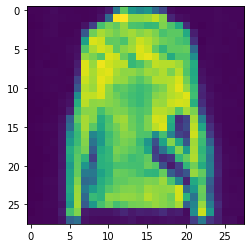

In [51]:
query = X_test[2]
print(query.shape)
plt.imshow(query.reshape(28,28))
print(query.shape)

In [81]:
codes = encoder.predict(X_train)

In [82]:
codes.shape

(60000, 4, 4, 8)

In [83]:
X_test[0].shape

(28, 28, 1)

In [84]:
query_codes = encoder.predict(X_test)

In [85]:
query_codes.shape

(500, 4, 4, 8)

In [86]:
from sklearn.neighbors import NearestNeighbors
n_neigh = 1
codes = codes.reshape(-1, 4*4*8); print(codes.shape)
query_codes = query_codes.reshape(-1, 4*4*8); print(query_codes.shape)

(60000, 128)
(500, 128)


In [87]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)
cs = []
for i in range(500):
    distances, indices = nbrs.kneighbors(np.array(query_codes[i].reshape(-1,128)))
    closest_images = X_train[indices]
    closest_images = closest_images.reshape(-1,28,28,1); 
    #print(closest_images.shape)
    codes1 = encoder.predict(closest_images)
    query_code1 = encoder.predict(X_test[i].reshape(1,28,28,1))
    #print(query_code1.shape)
    query_code1_temp = query_code1.reshape(128)
    #print(query_code1_temp)
    codes1_temp = codes1[0].reshape(128)
    #print(codes1_temp.shape)
    cs.append(np.dot(codes1_temp, query_code1_temp) / (np.linalg.norm(codes1_temp) * np.linalg.norm(query_code1_temp)))

In [88]:
print(cs)

[0.99501246, 0.9686748, 0.9915101, 0.99707, 0.99625176, 0.9864249, 0.9894067, 0.9925209, 0.99138474, 0.99033904, 0.99401814, 0.9958668, 0.99752694, 0.99457645, 0.98731303, 0.9948131, 0.9864569, 0.9879672, 0.98790205, 0.99583685, 0.9874806, 0.9896559, 0.9885667, 0.9869248, 0.9944122, 0.9891549, 0.9967306, 0.99360424, 0.9945361, 0.9696826, 0.99675244, 0.9817006, 0.996513, 0.9974565, 0.98671824, 0.995285, 0.9935752, 0.99497896, 0.97498214, 0.98912555, 0.9802392, 0.99657065, 0.9938915, 0.9957905, 0.9925277, 0.9851699, 0.996157, 0.99023074, 0.9699839, 0.9796194, 0.9874153, 0.9966462, 0.9976494, 0.97801065, 0.9980365, 0.99302894, 0.993971, 0.99227303, 0.9932936, 0.99351895, 0.994184, 0.9942373, 0.9984269, 0.9964125, 0.98050964, 0.99214226, 0.99559224, 0.99643064, 0.99767655, 0.9950872, 0.9866995, 0.9972178, 0.99131644, 0.993106, 0.985168, 0.9926706, 0.99000114, 0.99020797, 0.9922017, 0.99671394, 0.99486756, 0.99660563, 0.99068475, 0.9946564, 0.9924412, 0.97420514, 0.9945696, 0.9930913, 0.996

In [89]:
print(sum(cs)/len(cs))


0.9899980256557465


[1.]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]

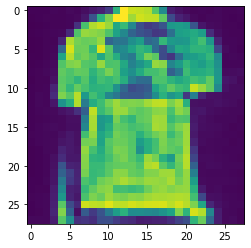

In [91]:
print(X_test_L[499])
plt.imshow(X_test[499].reshape(28,28))
print(X_test_L)

(28, 28, 1)


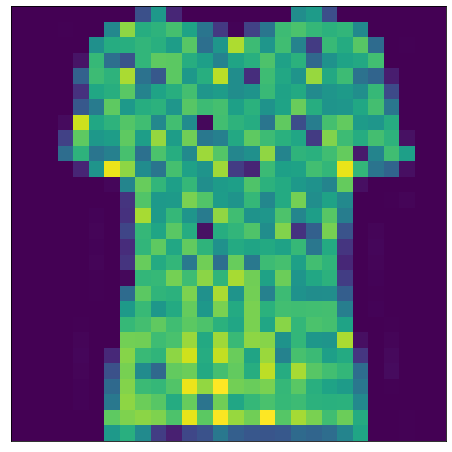

In [92]:
plt.figure(figsize=(20, 8))
for i in range(n_neigh):
    # display original
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(28, 28))
    print(closest_images[i].shape)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [66]:
codes1 = encoder.predict(closest_images)
query_code1 = encoder.predict(X_test[0].reshape(1,28,28,1))
print(query_code1.shape)
query_code1_temp = query_code1.reshape(128)
print(query_code1_temp)
codes1_temp = codes1[0].reshape(128)
print(codes1_temp.shape)
print(np.dot(codes1_temp, query_code1_temp) / (np.linalg.norm(codes1_temp) * np.linalg.norm(query_code1_temp)))

(1, 4, 4, 8)
[2.2427335  0.9136718  0.3900329  1.0778781  1.0546072  1.1725368
 2.292216   0.16958904 4.589869   2.1922348  0.2189847  2.0992372
 1.6842656  1.7894089  2.0000112  1.067383   3.8135724  3.703004
 0.32424974 2.2091317  1.9605626  1.2038901  0.95692015 0.98544943
 0.63433313 1.563587   0.23187327 1.1375701  1.9177736  0.04469847
 0.88229203 0.9587061  2.7043803  0.83744276 0.50507784 0.50393504
 1.253917   1.1311233  1.5226128  1.3380262  3.9350734  2.1963053
 0.         1.607269   1.524018   0.69846016 0.58357966 1.3416716
 3.8381987  3.5637212  0.35460594 1.6860129  1.5791187  0.81720835
 0.29233864 1.2780231  1.2861167  3.0718994  0.00899107 2.110485
 2.0416713  0.         0.46320343 0.8909964  2.6124356  0.57654256
 0.39952004 0.         1.3099345  1.3077011  1.4799944  1.9806856
 4.150769   2.0951104  0.6940289  1.1851759  1.7796512  1.2822707
 0.57226217 2.2274194  4.1820035  2.8003829  0.82303894 1.1656111
 1.9437609  1.2952595  0.00982405 2.1682658  1.9946626  3.23

In [67]:
print(query_code1_temp.shape)

(128,)


In [24]:
X_test = np.delete(X_test, 8, axis=0)

In [25]:
codes = encoder.predict(X_test)

In [26]:
codes.shape


(499, 4, 4, 8)

In [27]:
query_code = encoder.predict(query.reshape(1,28,28,1))

In [28]:
query_code.shape

(1, 4, 4, 8)

In [29]:
from sklearn.neighbors import NearestNeighbors
n_neigh = 5
codes = codes.reshape(-1, 4*4*8); print(codes.shape)
query_code = query_code.reshape(1, 4*4*8); print(query_code.shape)

(499, 128)
(1, 128)


In [30]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)
distances, indices = nbrs.kneighbors(np.array(query_code))
closest_images = X_test[indices]
closest_images = closest_images.reshape(-1,28,28,1); 
print(closest_images.shape)

(5, 28, 28, 1)


In [ ]:
# batchX, batchY = validation_generator.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

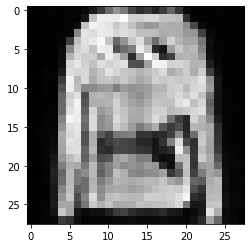

In [31]:
plt.imshow(query.reshape(28,28), cmap='gray')

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


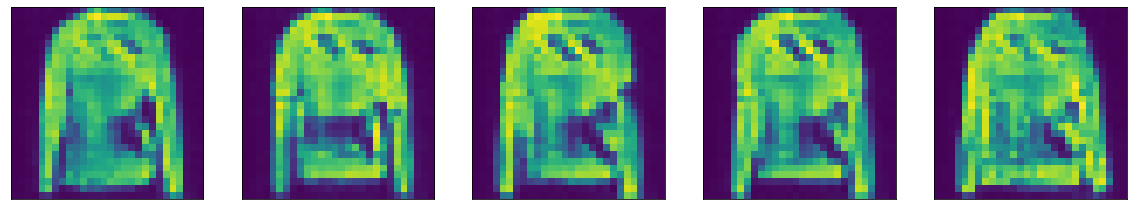

In [42]:
plt.figure(figsize=(20, 8))
for i in range(n_neigh):
    # display original
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(28, 28))
    print(closest_images[i].shape)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [41]:
closest_images[0].shape

(28, 28, 1)

In [33]:
codes1 = encoder.predict(closest_images)

In [34]:
print(codes1[0])

[[[2.8622673  0.8239482  0.40432307 0.8697711  1.0668973  1.4218044
   2.297845   0.83026403]
  [4.3758717  2.4891086  0.13780716 2.3197126  1.924981   1.5262511
   1.5553385  0.90146035]
  [3.9958699  3.5554454  0.16385943 2.0278358  1.7621665  1.4596639
   1.1559252  1.0848359 ]
  [1.1452419  2.4427125  0.10577709 1.9783981  2.2952752  0.09890664
   0.7812747  0.9453635 ]]

 [[2.8964565  0.9692764  0.40875357 0.68664044 1.1627725  1.2230012
   1.7321528  1.8710808 ]
  [3.971031   2.4772189  0.         1.6503892  1.7374636  0.57908016
   0.45453006 1.4827291 ]
  [4.019991   3.2807546  0.5323441  1.2840265  1.8930433  1.0543174
   0.41088155 2.1968625 ]
  [1.5309052  3.5879314  0.07812508 2.2664106  2.3729649  0.
   0.243841   1.1131471 ]]

 [[2.8883982  1.0592434  0.526362   0.6419712  1.4662455  1.4166467
   1.448501   2.091175  ]
  [3.5555131  2.246281   0.01634965 1.6125139  2.0013094  1.2729318
   0.772704   1.4127737 ]
  [3.1987078  2.8253114  0.4133165  1.2880819  2.001709   1.5

In [35]:
query_code1 = encoder.predict(query.reshape(1,28,28,1))
query_code1_temp = query_code1.reshape(128)
print(query_code1_temp.s)

[3.152003   0.85704714 0.3564255  0.89948857 1.1349943  1.4697609
 2.2711878  0.85486084 4.462257   2.739143   0.17157555 2.4399557
 2.099541   1.5561433  1.3411272  0.9931348  4.0113454  3.5842676
 0.14294809 2.0927868  1.7770792  1.4879086  1.1123658  1.2418116
 1.2068821  2.622052   0.06441821 2.1532822  2.2698138  0.04319351
 0.70615435 0.95480454 3.0603023  0.9894484  0.27767175 0.68423563
 1.2483678  1.2630358  1.7187995  2.0282853  4.176225   2.673359
 0.07212873 1.8305548  1.8561858  0.6390543  0.308642   1.6144218
 4.171287   3.2250826  0.6321825  1.3000191  1.8165153  1.1232142
 0.36213696 2.287732   1.6868342  3.6835818  0.15589717 2.2065063
 2.388162   0.         0.14712685 1.1779711  3.0351136  1.165737
 0.49321625 0.6785726  1.4754359  1.3979619  1.5580852  2.0923011
 3.5646684  2.3574476  0.08762089 1.854717   2.0186028  1.4706607
 0.90409875 1.7383815  3.3750527  2.7823126  0.55062526 1.3791429
 2.0023777  1.4943135  1.1461012  2.651088   1.7681063  3.4547164
 0.5186748

In [36]:
print(query_code1.shape)

(1, 4, 4, 8)


In [37]:
codes1_temp = codes1[0].reshape(128)
print(codes1_temp.shape)

(128,)


In [38]:
print(query_code1_temp-codes1_temp)

[ 0.2897358   0.03309894 -0.04789758  0.02971745  0.068097    0.04795647
 -0.0266571   0.02459681  0.08638525  0.25003433  0.03376839  0.12024307
  0.17455995  0.02989221 -0.21421134  0.09167445  0.01547551  0.02882218
 -0.02091134  0.06495094  0.01491272  0.02824473 -0.04355931  0.15697575
  0.06164026  0.17933941 -0.04135888  0.17488408 -0.02546144 -0.05571312
 -0.07512033  0.00944102  0.16384578  0.020172   -0.13108182 -0.00240481
  0.08559525  0.04003453 -0.01335335  0.15720451  0.20519423  0.19614005
  0.07212873  0.18016565  0.1187222   0.05997413 -0.14588806  0.13169277
  0.15129614 -0.05567193  0.09983838  0.01599264 -0.07652795  0.06889689
 -0.04874459  0.09086943  0.15592897  0.09565043  0.07777209 -0.05990434
  0.01519704  0.         -0.09671415  0.06482399  0.1467154   0.10649359
 -0.03314576  0.03660142  0.00919032 -0.01868486  0.10958421  0.00112605
  0.00915527  0.11116672  0.07127125  0.24220312  0.01729345  0.19772887
  0.13139474  0.32560778  0.17634487 -0.04299879  0

In [39]:
print(np.dot(codes1_temp, query_code1_temp) / (np.linalg.norm(codes1_temp) * np.linalg.norm(query_code1_temp)))

0.99851274


In [ ]:
cos = np.dot(codes1_temp, query_code1) / (np.sqrt(numpy.dot(codes1_temp,codes1_temp)) * np.sqrt(numpy.dot(query_code1,query_code1)))

In [ ]:
# from keras.preprocessing.image import load_img
# # load the image
# img = load_img('classes/0/img_20200428-234715_0.png')
# # report details about the image
# print(type(img))
# print(img.format)
# print(img.mode)
# print(img.size)
# # show the image
# img.show()

In [ ]:
#loss = autoencoder.evaluate_generator(validation_generator, steps=48)

In [43]:
print(X_test.shape)

(499, 28, 28, 1)
